In [10]:
from keras.models import Sequential,load_model
from keras.layers import LeakyReLU,Conv2D,Activation, MaxPooling2D,Dense,Flatten
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score,roc_curve,confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt_False_Positive_vs_True_Positive

In [11]:
def Build_CNN_Model():
    
    # -------------------------------------------------------------------------
    #                        Build CNN Model 
    # -------------------------------------------------------------------------
    model = Sequential()
    
    #  First Block of CNN
    model.add(Conv2D(8, (5, 5), padding='same', input_shape=(224, 224, 3)))  
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((2, 2)))
    
    #  Second Block of CNN
    model.add(Conv2D(8, (3, 3),  padding='same'))  
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((2, 2)))

    #  Third Block of CNN
    model.add(Conv2D(16, (3, 3),  padding='same'))  
    model.add(LeakyReLU(alpha=0.1))


    #  Forth Block of CNN
    model.add(Conv2D(16, (3, 3),  padding='same'))  
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((2, 2)))

    
    #  Flatten and Fully Connected Layer
    model.add(Flatten())
    model.add(Dense(10))
    model.add(LeakyReLU(alpha=0.1))
     
    #  Softmax Classifier
    model.add(Dense(2))
    model.add(Activation('softmax'))
        
    #  Display model
    model.summary()
    
	# compile model

    opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model 


In [12]:
# train and evalluate cnn model
def Train_CNN_Model(model):
    
    # -------------------------------------------------------------------------
    #                        Train CNN Model 
    # -------------------------------------------------------------------------
    
    
    # create data generators    
    train_datagen = ImageDataGenerator(
                                     rescale=1.0/255.0,
                                     featurewise_center= True,
                                     featurewise_std_normalization = True,
                                     rotation_range=10,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,                                     
                                     brightness_range=[0.2,1.0],
                                     )
    
    valid_datagen = ImageDataGenerator(
                                     rescale=1.0/255.0,
                                     featurewise_center= True,
                                     featurewise_std_normalization = True)
    
  
   
    # prepare iterators
    batch_size=32
    train_it = train_datagen.flow_from_directory('Data/train/',classes =('normal','abnormal'),batch_size=batch_size, target_size=(224, 224))
    valid_it = valid_datagen.flow_from_directory('Data/val/',classes =('normal','abnormal'),batch_size=batch_size, target_size=(224, 224))


    epochs=100;
    
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=valid_it, validation_steps=len(valid_it), epochs=epochs, verbose=1)
    
    
    #  "Accuracy"
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

	# save model
    model.save('medical_diagnosis_cnn_model.h5')

In [13]:
def Evaluate_CNN_Model():
    # -------------------------------------------------------------------------
    #                        Evaluate CNN Model 
    # -------------------------------------------------------------------------
    
    # load model
    model = load_model('medical_diagnosis_cnn_model.h5')
    
    # load test data
    batch_size=32
    test_datagen = ImageDataGenerator(
                                     rescale=1.0/255.0,
                                     featurewise_center= True,
                                     featurewise_std_normalization = True)
    
    test_it = test_datagen.flow_from_directory('Data/test/',classes =('normal','abnormal'), 
                                               shuffle=False,batch_size=batch_size, target_size=(224, 224))
    
    y_true = test_it.classes;

    y_pred = model.predict_generator(test_it, steps=len(test_it), verbose=1)

    
    y_pred_prob = y_pred[:,1]

     
    y_pred_binary =  y_pred_prob > 0.5
   
    #Confution Matrix    
    print('\nConfusion Matrix\n -------------------------')    
    print(confusion_matrix(y_true,y_pred_binary));
    
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_true, y_pred_binary)
    print('Accuracy: %f' % accuracy)
    
    
    # precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred_binary)
    print('Precision: %f' % precision)
    
    # recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred_binary)
    print('Recall: %f' % recall)
    
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_pred_binary)
    print('F1 score: %f' % f1)    
       
    # ROC AUC
    auc = roc_auc_score(y_true, y_pred_prob)
    print('ROC AUC: %f' % auc)
    
    
    # calculate roc curves
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
        
    # plot the roc curve for the model
    plt.figure()
    plt_False_Positive_vs_True_Positive.plot(fpr, tpr, linestyle='--', label='')
    
    # axis labels
    plt_False_Positive_vs_True_Positive.xlabel('False Positive Rate')
    plt_False_Positive_vs_True_Positive.ylabel('True Positive Rate')
       
    # show the legend
    plt_False_Positive_vs_True_Positive.legend()
    # show the plot
    plt_False_Positive_vs_True_Positive.show()
    


In [14]:
# main entry
    
model = Build_CNN_Model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 8)       608       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 224, 224, 8)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 8)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 8)       584       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 112, 112, 8)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 8)        0         
 2D)                                                  

Found 600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


C:\Users\STUDEN~1\AppData\Local\Temp/ipykernel_4420/2981904013.py:36: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_it, steps_per_epoch=len(train_it),


Epoch 1/100
19/19 [==============================] - 169s 9s/step - loss: 0.6592 - accuracy: 0.6550 - val_loss: 0.4869 - val_accuracy: 0.8050
Epoch 2/100
19/19 [==============================] - 160s 9s/step - loss: 0.5774 - accuracy: 0.7267 - val_loss: 0.6240 - val_accuracy: 0.6125
Epoch 3/100
19/19 [==============================] - 192s 10s/step - loss: 0.4670 - accuracy: 0.8083 - val_loss: 0.2457 - val_accuracy: 0.8900
Epoch 4/100
19/19 [==============================] - 192s 10s/step - loss: 0.3655 - accuracy: 0.8533 - val_loss: 0.2666 - val_accuracy: 0.9150
Epoch 5/100
19/19 [==============================] - 155s 8s/step - loss: 0.3753 - accuracy: 0.8300 - val_loss: 0.2840 - val_accuracy: 0.8725
Epoch 6/100
19/19 [==============================] - 158s 8s/step - loss: 0.3761 - accuracy: 0.8350 - val_loss: 0.2648 - val_accuracy: 0.9125
Epoch 7/100
19/19 [==============================] - 173s 9s/step - loss: 0.3030 - accuracy: 0.8817 - val_loss: 0.2012 - val_accuracy: 0.9325
Epoc

19/19 [==============================] - 97s 5s/step - loss: 0.1407 - accuracy: 0.9533 - val_loss: 0.2314 - val_accuracy: 0.9200
Epoch 59/100
19/19 [==============================] - 95s 5s/step - loss: 0.1865 - accuracy: 0.9300 - val_loss: 0.1864 - val_accuracy: 0.9425
Epoch 60/100
19/19 [==============================] - 106s 6s/step - loss: 0.1824 - accuracy: 0.9417 - val_loss: 0.2940 - val_accuracy: 0.9050
Epoch 61/100
19/19 [==============================] - 103s 5s/step - loss: 0.1448 - accuracy: 0.9483 - val_loss: 0.2125 - val_accuracy: 0.9375
Epoch 62/100
19/19 [==============================] - 109s 6s/step - loss: 0.1095 - accuracy: 0.9667 - val_loss: 0.3101 - val_accuracy: 0.9175
Epoch 63/100
19/19 [==============================] - 102s 5s/step - loss: 0.1549 - accuracy: 0.9400 - val_loss: 0.2156 - val_accuracy: 0.9375
Epoch 64/100
19/19 [==============================] - 105s 6s/step - loss: 0.1712 - accuracy: 0.9267 - val_loss: 0.1709 - val_accuracy: 0.9525
Epoch 65/100
1

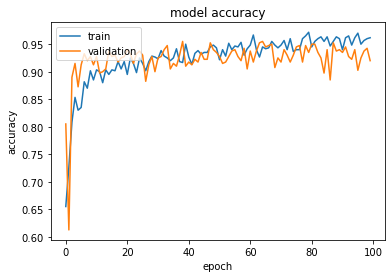

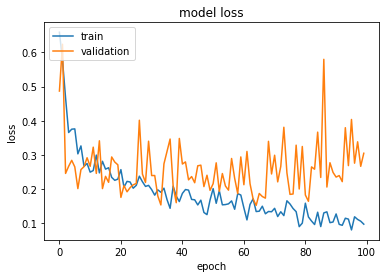

In [15]:
Train_CNN_Model(model)

Found 624 images belonging to 2 classes.


C:\Users\STUDEN~1\AppData\Local\Temp/ipykernel_4420/1273337992.py:21: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_it, steps=len(test_it), verbose=1)


20/20 [==============================] - 30s 1s/step


No handles with labels found to put in legend.



Confusion Matrix
 -------------------------
[[201  33]
 [ 36 354]]
Accuracy: 0.889423
Precision: 0.914729
Recall: 0.907692
F1 score: 0.911197
ROC AUC: 0.926271


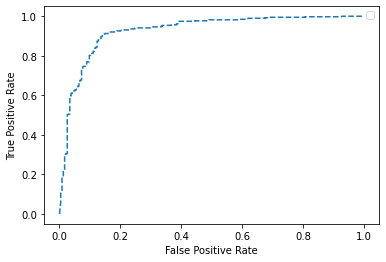

In [16]:
Evaluate_CNN_Model()